## About this File
- I will pull in a playlist from spotify's release radar, meaning very new music 
- I will run voting/forest classifiers and see which does better
- I will analyze the results at the end

In [237]:
import pandas as pd
import numpy as np

In [238]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
cid ="186e8d1297e24171a54f8cff036b0426" 
secret = "033eaa62aa4a4383bd2102e5aa83ea6f"
username = "mcbabe17"
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'user-library-read playlist-read-private playlist-modify-private user-modify-playback-state playlist-read-collaborative playlist-modify-public user-top-read user-read-currently-playing app-remote-control playlist-modify-private user-library-read'
token = util.prompt_for_user_token(username, scope, cid, secret, 'http://localhost:8080')
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)


In [135]:
rap_songs = sp.playlist('448Hwhpqil1JyN1JQtaQoo')

In [247]:
for item in sp.current_user_playlists()['items']:
    if item['name'] == 'rap':
        print(item['id'])

0hDbGa7JGMGeDdpyUuSoQu


In [248]:
rap_songs2 = sp.playlist('0hDbGa7JGMGeDdpyUuSoQu')

In [249]:
rap_song_ids = []
for item in rap_songs['tracks']['items']:
    rap_song_ids.append(item['track']['id'])
    #print(item['track']['id'], item['track']['name'])
    
rap_song_ids2 = []
for item in rap_songs2['tracks']['items']:
    rap_song_ids2.append(item['track']['id'])

In [100]:

feature_bad_keys = ['type', 'id', 'uri', 'track_href', 'analysis_url']  # keys to ignore
rows = []

for song in rap_song_ids:
    try:
        row = {'id': sp.track(song)['id']}
        for key, value in sp.audio_features(song)[0].items():
            if key not in feature_bad_keys:
                row[key] = value
        row['num_sections'] = len(sp.audio_analysis(song)['sections'])
        track = sp.track(song)
        row['explicit'] = 0 if track['explicit'] == False else 1
        row['song_name'] = track['name']

        row['popular'] = 0 if sp.track(song)['popularity'] < 50 else 1
        to_add = [row['id'], row['song_name'], row['danceability'], row['energy'], row['key'], row['loudness'],
                  row['mode'], row['speechiness'], row['acousticness'], row['instrumentalness'], row['liveness'],
                  row['valence'], row['tempo'], row['duration_ms'], row['time_signature'], row['num_sections'],
                  row['explicit'], row['popular']]
        rows.append(to_add)
    except:
        continue





HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/0E72UaOjGEOHJliDjq6Ivw returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/2YGHCHkWTbtCUTjL0LUXtx returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/53Z2zWV2bz7vKonoN31xV9 returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/7rv7Luf0tlF9c0VloFndJZ returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/637ni2okXtqGksPKKQFUft returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/55f7NsJibzWMvB15OEN0Zx returned 404 due to analysis not found


In [295]:
df = pd.DataFrame(rows, columns=['id', 'song_name', 'danceability', 'energy', 'key', 'loudness',
                           'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                           'valence', 'tempo', 'duration_ms', 'time_signature', 'num_sections', 
                            'explicit', 'popular'])


In [296]:
df = df[df.speechiness >= .22]


In [297]:
df.shape

(27, 18)

In [299]:
names = df.song_name


In [300]:
df['duration_per_num_sections'] = df.duration_ms / df.num_sections


In [301]:
df.drop('num_sections', axis=1, inplace=True)


In [302]:
# musical_key encoding
keys = pd.get_dummies(df.key, prefix='key_', drop_first=True)
df = pd.concat([df.drop('key', axis=1), keys], axis=1)



In [303]:
# time_signature encoding
sigs = pd.get_dummies(df.time_signature, prefix='time_sig_', drop_first=True)
df = pd.concat([df.drop('time_signature', axis=1), sigs], axis=1)


In [304]:
df.drop(['id', 'song_name'], inplace=True, axis=1)


In [306]:
target = df.popular
df.drop('popular', axis=1, inplace=True)



In [307]:
df['no_instruments'] = np.where(df.instrumentalness == 0, 1, 0)


In [308]:
df['time_sig__1'] = 0
df['time_sig__3'] = 0
df['key__2'] = 0
df['key__3'] = 0



In [309]:
df = df[['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
         'liveness', 'valence', 'tempo', 'duration_ms', 'explicit', 'duration_per_num_sections', 'key__1', 
         'key__2', 'key__3', 'key__4', 'key__5', 'key__6', 'key__7', 'key__8', 'key__9', 'key__10', 
         'key__11', 'time_sig__1', 'time_sig__3', 'time_sig__4', 'time_sig__5', 'no_instruments']]



['danceability', 'energy', 'loudness', 'musical_mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'explicit', 'duration_per_num_sections', 'key__1',
       'key__2', 'key__3', 'key__4', 'key__5', 'key__6', 'key__7', 'key__8',
       'key__9', 'key__10', 'key__11', 'time_sig__1', 'time_sig__3',
       'time_sig__4', 'time_sig__5', 'no_instruments']

In [310]:
df.columns = ['danceability', 'energy', 'loudness', 'musical_mode', 'speechiness', 'acousticness', 
              'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'explicit', 
              'duration_per_num_sections', 'key__1', 'key__2', 'key__3', 'key__4', 'key__5', 'key__6', 
              'key__7', 'key__8', 'key__9', 'key__10', 'key__11', 'time_sig__1', 'time_sig__3', 'time_sig__4', 
              'time_sig__5', 'no_instruments']


In [311]:
len(df.columns)

29

In [313]:
forest = pd.read_pickle("forest.pickle")
voting = pd.read_pickle("voting.pickle")

In [314]:
forest_preds = forest.predict(df)
voting_preds = voting.predict(df)


In [315]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score

In [316]:
print(f"Accuracy: {accuracy_score(target, forest_preds)}")
print(f"F1 Score: {f1_score(target, forest_preds)}")

Accuracy: 0.5925925925925926
F1 Score: 0.56


In [317]:
print(f"Accuracy: {accuracy_score(target, voting_preds)}")
print(f"F1 Score: {f1_score(target, voting_preds)}")

Accuracy: 0.6296296296296297
F1 Score: 0.6153846153846153


In [325]:
import seaborn as sns
%matplotlib inline

In [328]:
target.value_counts()

1    17
0    10
Name: popular, dtype: int64

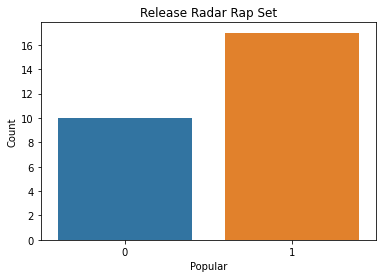

In [331]:
sns.barplot(target.value_counts().index, target.value_counts())
plt.title('Release Radar Rap Set')
plt.ylabel('Count')
plt.xlabel('Popular')
plt.savefig("pics/release_radar_pop_count.png")

### Things that might explain worse performance from original rap set
- As we can see by the distribution of popularity in this set, the majority of songs are popular
- This is quite different than the set we trained on, which was the opposite (maybe 1 was popular for every 4 songs)
- So, why is this the case?
- Spotify's popularity algorithm has a time series component to it. Basically, it weighs the amount of plays against how recent those plays were. This is big. Since these songs are all knew, even if the play count isn't that high, the plays are very recent, and so the popularity is likely inflated relative to the set I trained on. 
- This explains by the difference in popularity distribution of the two sets, as well as the big drop in model performance.
- From this, it is obvious that I would need to incorporate some kind of time analysis in my model
- Perhaps run a regression on popularity looking at days_since_release as well as view_count